# Python Dependencies

In [272]:
# Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import os
from tensorflow.keras import layers
import time
import kaggle
from scipy.fft import fft, fftfreq, ifft, rfft, rfftfreq, irfft

# Defining Constants

In [273]:
# Defining constants
PATH = 'data/'
TRAIN_CSV = PATH + 'train.csv'
TEST_CSV = PATH + 'test.csv'
SUBMISSION_CSV = PATH + 'submission.csv'
TEST_EEGS = PATH + 'test_eegs/'
TRAIN_EEGS = PATH + 'train_eegs/'
TEST_SPECTROGRAMS = PATH + 'test_spectrograms/'
TRAIN_SPECTROGRAMS = PATH + 'train_spectrograms/'

# Defining the duration time for eeg and spectrogram respectively
eeg_duration = 10000
spectrogram_duration = 300

eeg_time = 50
spectrogram_time = 10 * 60

eeg_sample_rate = 200

# General Function

In [274]:
#### Function to Take an EEG and Fourier Tranform it ####

# Assumption:   - The eeg_data is a 1D numpy array
#               - The eeg_data is a time series data
#               - The eeg_data comprises of sums of sine or cosine waves (with a little bit of noise)

# This function takes in an EEG data and plots the original signal, calculates the fourier transform and plots the 
# filtered signal.

# fourier_transform_eeg(eeg_data :: np.array, SAMPLE_RATE :: int, DURATION :: int) 
#                                       -> np.array(2, 20, DURATION / 2 + 1): 

def fourier_transform_eeg(eeg_data, SAMPLE_RATE = eeg_sample_rate, DURATION = eeg_time):
    # Creating a list to store the filtered signals
    filtered_signals = [[],[]]

    for i in range(eeg_data.shape[0]):
        # Getting the amplitude and frequency of the signal
        amplitude = rfft(eeg_data[i])
        frequency = rfftfreq(SAMPLE_RATE * DURATION, 1 / SAMPLE_RATE)

        filtered_signals[0].append(amplitude)
        filtered_signals[1].append(frequency)

    filtered_signals = np.array(filtered_signals)
    return filtered_signals

In [275]:
#### Function to visualize a Fourier Tranformed EEG ####

def visualize_inverse_fourier(transformed_eeg_data):
    nx = 5
    ny = 4

    figure, axis = plt.subplots(nx, ny, figsize=(20, 20))
    figure.supxlabel("Time(s)")
    figure.supylabel("Voltage (micro volts)")

    for i in range(transformed_eeg_data.shape[1]):
        # Reconstructing the filtered signal using the inverse Fourier transform
        amplitude, frequency = transformed_eeg_data[:,i]
        reconstructed_signal = irfft(amplitude)
        axis[i // ny, i % ny].plot(reconstructed_signal, 
                                    label="Reconstructed Signal", 
                                    color="blue")

    plt.show()

In [276]:
#### Function to Visualize an EEG ####

def visualize_eeg(eeg_data):
    nx = 5
    ny = 4

    figure, axis = plt.subplots(nx, ny, figsize=(20, 20))
    figure.supxlabel("Time(s)")
    figure.supylabel("Voltage (micro volts)")

    for i in range(eeg_data.shape[0]):
        axis[i // ny, i % ny].plot(eeg_data[i], 
                                    label="Filtered Signal", 
                                    color="red")

    plt.show()

In [277]:
#### Function to Fetch all the data required ####

### Explained the process below in Detail ###

def get_input_data(length=1000):
    # Reading from the train csv
    train_data = pd.read_csv(TRAIN_CSV)

    list_of_X_train = []
    list_of_Y_train = []

    for i in range(1, length + 1):
        # Getting the i^th eeg and spectrogram data id respectively
        eeg_id = train_data['eeg_id'][i]

        # Getting the first label offset seconds for eeg and spectrogram respectively
        eeg_label_offset_seconds = train_data['eeg_label_offset_seconds'][i] * eeg_sample_rate

        # Reading the eeg and spectrogram data with the aforementioned ids
        eeg = pd.read_parquet(TRAIN_EEGS + f'{eeg_id}.parquet')

        # Takes the 50 second sample of the eeg data
        eeg = eeg.loc[eeg_label_offset_seconds : eeg_label_offset_seconds + eeg_duration - 1,]
        eeg = eeg.to_numpy().T
        # Each row represents a time point with all the node.
        # Each column represents a node at all time points one by one.

        # Votes for each class
        seizure_vote = train_data['seizure_vote'][i]
        lpd_vote = train_data['lpd_vote'][i]
        gpd_vote = train_data['gpd_vote'][i]
        lrda_vote = train_data['lrda_vote'][i]
        grda_vote = train_data['grda_vote'][i]
        other_vote = train_data['other_vote'][i]

        # Defining the new X_train and Y_train
        y_train = np.array([seizure_vote, 
                                lpd_vote, 
                                gpd_vote, 
                                lrda_vote, 
                                grda_vote, 
                                other_vote])
        x_train = fourier_transform_eeg(eeg).T.flatten().real.tolist()
        list_of_X_train.append(x_train)
        list_of_Y_train.append(y_train)

    return list_of_X_train, list_of_Y_train

X_train_list, Y_train_list = get_input_data(100)

X_train_list = np.array(X_train_list)
Y_train_list = np.array(Y_train_list)

print("X train's size: ", X_train_list.size)
print("Y train's size: ", Y_train_list.size)

print("X train's shape: ", X_train_list.shape)
print("Y train's shape: ", Y_train_list.shape)

X train's size:  20004000
Y train's size:  600
X train's shape:  (100, 200040)
Y train's shape:  (100, 6)


# Loading One Sample Data

In [278]:
train = pd.read_csv(TRAIN_CSV)
test = pd.read_csv(TEST_CSV)

eeg_id = train['eeg_id'][0]
spectrogram_id = train['spectrogram_id'][0]

eeg_offset = train['eeg_label_offset_seconds'][0]
spectrogram_offset = train['spectrogram_label_offset_seconds'][0]

eeg = pd.read_parquet(f'{TRAIN_EEGS}{eeg_id}.parquet').loc[eeg_offset : eeg_offset + eeg_duration - 1,]
eeg = eeg.T.to_numpy()

spectrogram = pd.read_parquet(f'{TRAIN_SPECTROGRAMS}{spectrogram_id}.parquet').loc[spectrogram_offset : spectrogram_offset + spectrogram_duration - 1,]
spectrogram = spectrogram.T.to_numpy()

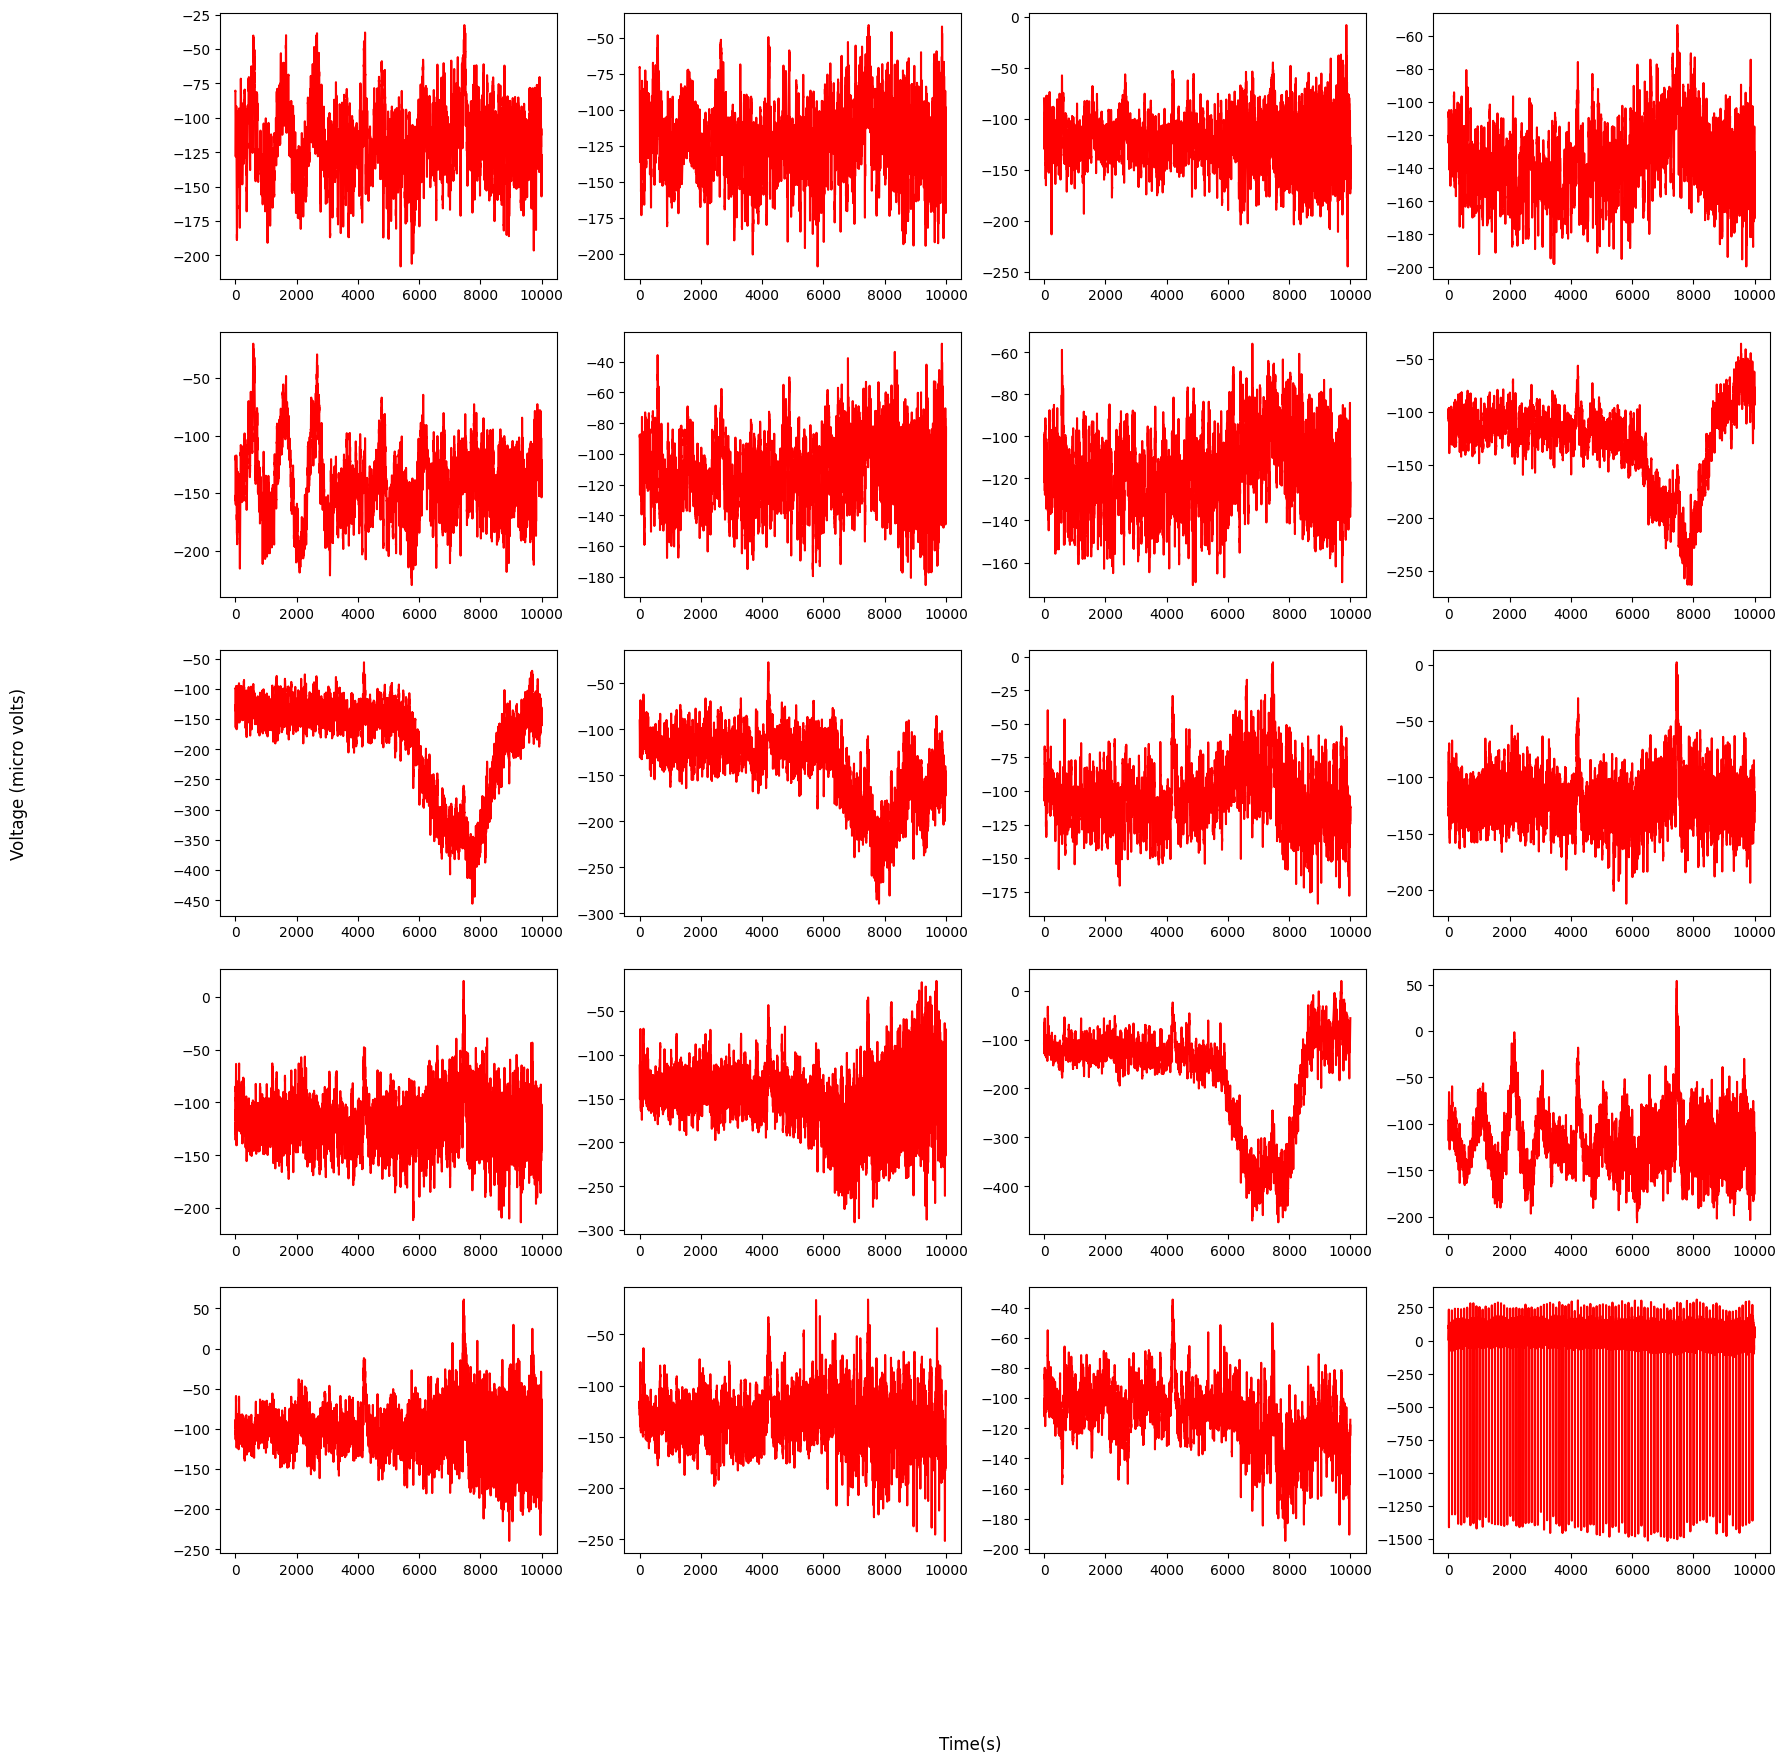

In [279]:
visualize_eeg(eeg)

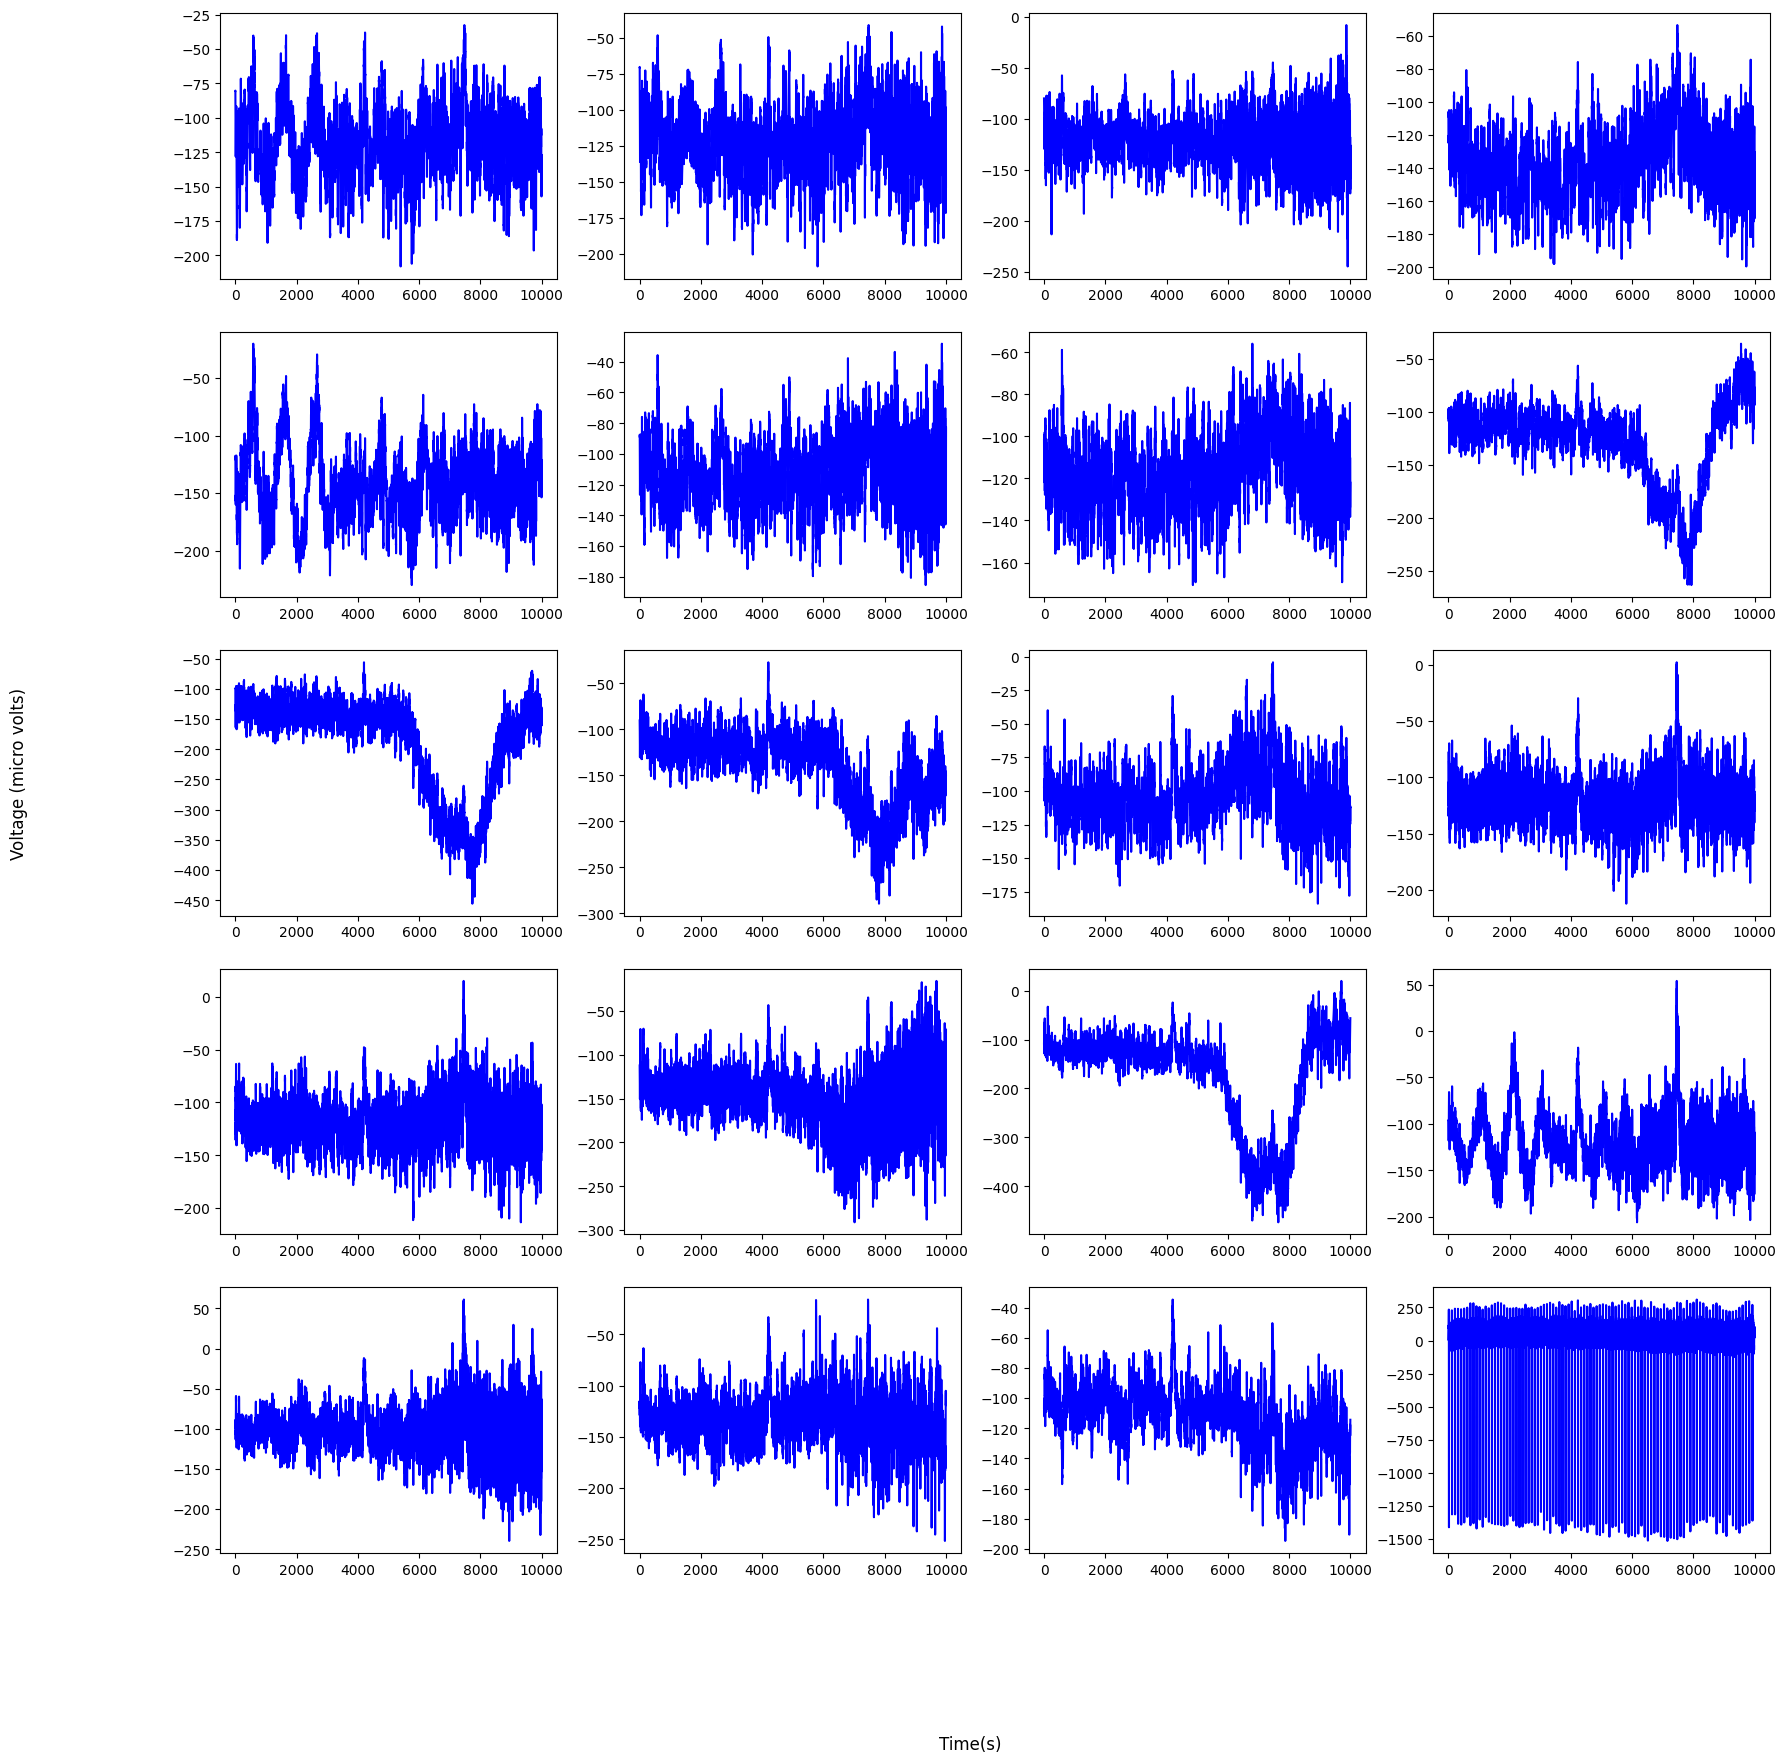

In [280]:
transformed_eeg_list = fourier_transform_eeg(eeg)
visualize_inverse_fourier(transformed_eeg_list)

In [281]:
print("Size of the fourier transformed signal: ", transformed_eeg_list.shape)
print("Data points for an entire EEG signal: ", transformed_eeg_list.size)

Size of the fourier transformed signal:  (2, 20, 5001)
Data points for an entire EEG signal:  200040


# Running Model

In [282]:
# Callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,
 restore_best_weights=True)

ReduceOnPlateau = keras.callbacks.ReduceLROnPlateau(
monitor='val_loss',
factor=0.1,
patience=10,
)

root_logdir = os.path.join(os.curdir, "logs")

def get_run_logdir():
 run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
 return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [283]:
# Model Architecture:
model = keras.models.Sequential([
 keras.layers.Dense(units=3, activation='relu'),
 layers.BatchNormalization(),
 keras.layers.Dense(units=32, activation='relu'),
 layers.BatchNormalization(),
 keras.layers.Dense(units=16, activation='relu'),
 layers.BatchNormalization(),
 keras.layers.Dense(units=1, activation='sigmoid'),
])

In [284]:
# Model Compilation
model.compile(loss="mse",
              optimizer="sgd",
              metrics=["accuracy"])


In [285]:
# Model Training
history = model.fit(X_train_list, Y_train_list, batch_size=3, steps_per_epoch=1,
                    epochs=5,validation_split=0.2,
                    callbacks=[tensorboard_cb,early_stopping_cb,ReduceOnPlateau])

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step - accuracy: 0.6111 - loss: 1.0969 - val_accuracy: 0.6333 - val_loss: 15.9552 - learning_rate: 0.0100
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2778 - loss: 16.9784 - val_accuracy: 0.6333 - val_loss: 15.8428 - learning_rate: 0.0100
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3333 - loss: 14.6202 - val_accuracy: 0.6333 - val_loss: 15.5332 - learning_rate: 0.0100
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3333 - loss: 0.8321 - val_accuracy: 0.6333 - val_loss: 15.5195 - learning_rate: 0.0100
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3333 - loss: 10.8770 - val_accuracy: 0.6083 - val_loss: 15.1931 - learning_rate: 0.0100


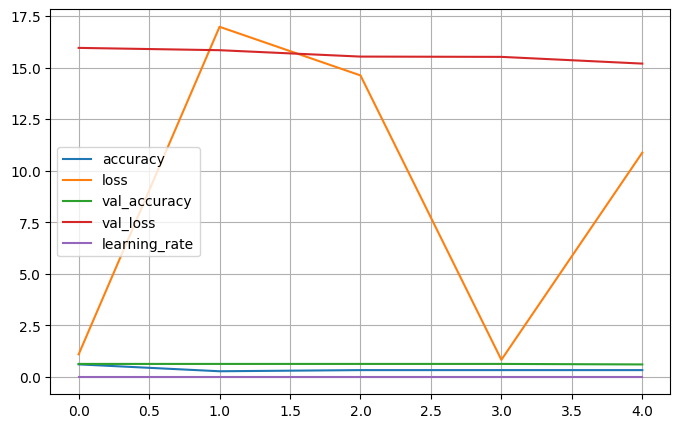

In [287]:
# Plot Metrics
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()